## *Historical and Sociocultural Analysis of the Impact of World Events on Film Genre Trends*

 This project will explore historical trends in film genres, analyzing how societal and historical events—such as wars, economic shifts, and cultural influences—affect the popularity of genres. 
 It will also examine the impact of culture and globalization on global film production. The goal is to understand how historical events and cultural dynamics shape film genre trends over time and understand how periods of conflict, economic upheaval, or stability shape audience preferences and genre popularity.

In [18]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
import geopandas as gpd
import plotly.graph_objects as go
from IPython.display import Image
%load_ext autoreload
%autoreload 2
from src.utils.data_cleaning2 import *
from src.utils.visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Movies Dataset

For this part of the notebook we will use the movie dataset provided. We cleaned it and then preprocessed it for our project. We will then focus on some keys columns that will be useful for our project: Notamment les genres des movies and the countries involved in the production. 

In [19]:
raw_movies_data = pd.read_csv("data/MoviesDataset/movie.metadata.zip", header= None, delimiter='\t')
clean_movies_data = preprocessed_movies(raw_movies_data)
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [21]:
preprocessed_movies = pd.read_csv(processed_data_path)
preprocessed_movies.head(2)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000


### MOVIES GENRES

In this section, we will examine how movies are classified into genres. Carefully analyzing, selecting and refining these genre classifications is essential for obtaining meaningful insights. 
We will discuss our approach to selecting and adjusting genres for our following study. 

In [22]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Genres'].str.split(', ').explode().unique()

print(f"There are {len(genres)} genres in the dataset")

There are 362 genres in the dataset


Movies are classified into a wide variety of genres that reflect themes, styles, cultural contexts, narrative forms, or settings. However, not all of these dimensions are directly relevant to our analysis, so it is necessary to select genres that enable meaningful grouping of films.

There are several approaches we could take to group movies:
1. Select the most popular genres.
2. Identify correlations between genres to consolidate them into broader categories.
3. Manually select the genres most relevant to our analysis.

We will explore the first two options, and if they prove insufficient, we will resort to the third approach, which remains feasible given that manually handling 300 genres is manageable.

#### 1) Most Popular Genre

Number of genres assigned to more than 50 movies: 196.


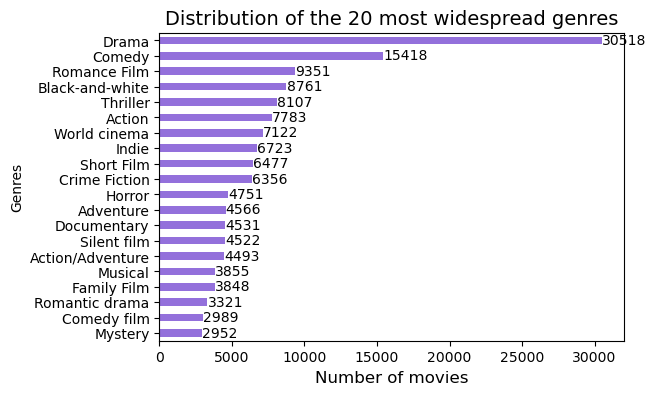

In [36]:
genres_counts = preprocessed_movies['Genres'].str.split(', ').explode().value_counts()

#Only keep genres that have been assigned to more than 50 movies
threshold = 50
relevant_genres = genres_counts[genres_counts > threshold]
print(f"Number of genres assigned to more than {threshold} movies: {len(relevant_genres)}.")

#20 most widespread genres
top_20_genres = relevant_genres.head(20)

plt.figure(figsize=(6, 4))
top_20_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies', fontsize=12)
plt.title('Distribution of the 20 most widespread genres', fontsize=14)
plt.gca().invert_yaxis() 

for index, value in enumerate(top_20_genres):
    plt.text(value + 10, index, str(value), va='center')
plt.show()

Many genres in the dataset may not be meaningful for our analysis because they contain very few movies, making it difficult to observe any trends over time for these genres. To focus on relevant genres, we can set an arbitrary threshold for the minimum number of movies assigned to each genre.

We also reviewed the top 20 genres to examine their distribution and identify which ones might be significant.

One immediate observation is that the genres are not inherently comparable, as they often describe entirely different aspects of a film. For example, comparing trends between "Black-and-White Film" and "Comedy" is problematic. The former describes a technical characteristic, while the latter defines the tone or mood of a film, and these categories are not mutually exclusive. A film can be both a black-and-white film and a comedy simultaneously. 

### 2) Correlation Between Genres

Based on the genre names alone, we can anticipate that certain genres might be correlated, appearing together frequently in movies. To explore these relationships, we’ll create a heatmap to visualize genre associations and identify any genres that are commonly paired in films.

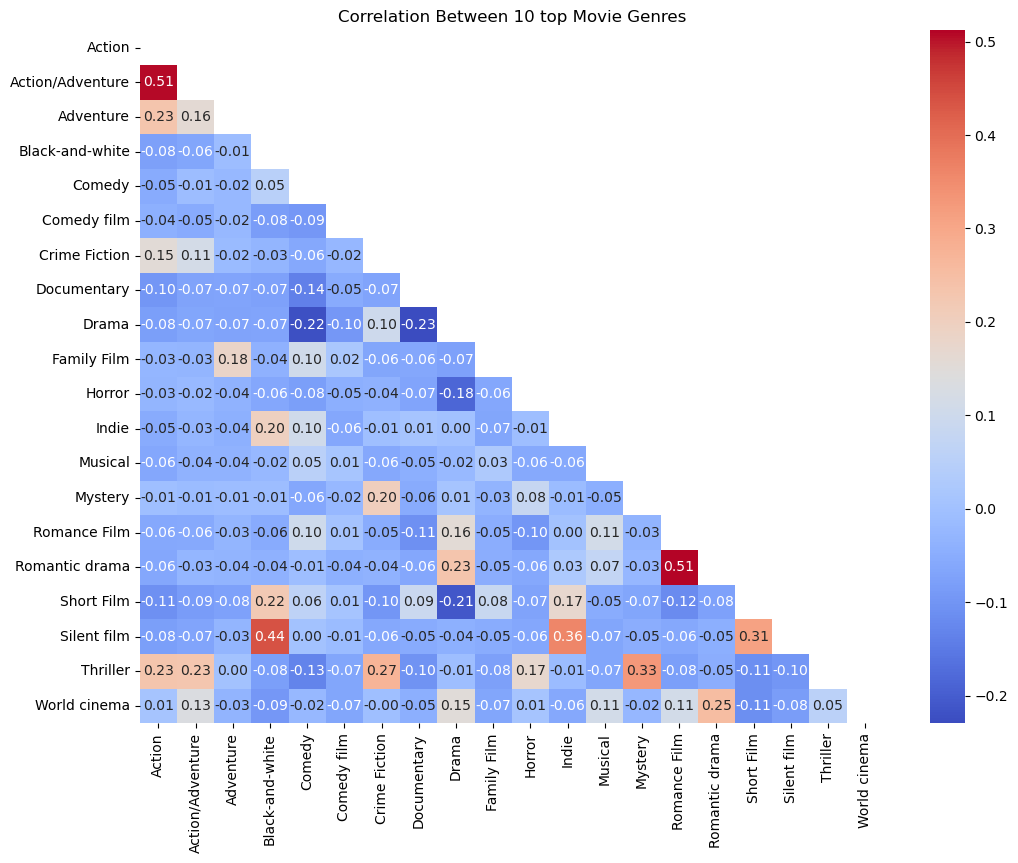

In [43]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genres', 'Count']

genre_counts_top_20 = genre_counts.iloc[:20]
most_20commongenres,coverage20 = most_common_genres(preprocessed_movies, genre_counts_top_20, 20)
most_20commongenres = most_20commongenres.dropna(subset=['Genres'])

#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_20commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_20commongenres.index)
genre_correlation = genre_binary_matrix.corr()

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')
plt.show()

This heatmap illustrates how frequently two genres are used together to describe the same movie.

For example, the combination of "Crime Fiction" and "Thriller" shows a moderate positive correlation (0.26), suggesting that these genres often co-occur, meaning that movies labeled as "Crime Fiction" frequently include elements of "Thriller" as well. However, this co-occurrence is only moderately consistent across the dataset.

On the other hand, "Drama" and "Documentary" have a strong negative correlation (-0.28), indicating that these genres are rarely used together. This suggests that movies classified as "Drama" are typically not labeled as "Documentary" and vice versa.

We also observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.

### 3)Manually select relevant genre